In [1]:
%matplotlib inline
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats

# Plotting setup
# set_matplotlib_formats("pdf", "svg")
plt.rcParams["text.usetex"] = False
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"


import torch
import torch.nn as nn
import torch.nn.functional as F

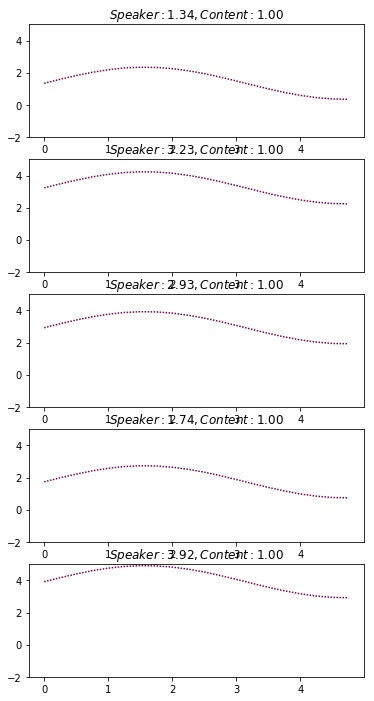

In [90]:

fig, axes = plt.subplots(nrows=5,ncols=1,figsize=(6,12))


xs = np.arange(0,5, .25)


# generative process in real world
# a, b = 1, 10
# y = np.sin(a * x) + np.sin(b * x)



training_samples = []
num_speakers = 5

# let's take some samples from 'the real world'
# for a in range(5):
content_factor = 1#np.random.normal(0, 1)
for speaker_id in range(num_speakers):
    speaker_factor = np.random.normal(2, 1)

    y = content_factor * np.sin(xs) + speaker_factor
    training_samples.append(torch.unsqueeze(torch.unsqueeze(torch.Tensor(y), 0),0))

    axes[speaker_id].plot(xs, y,linestyle = (0, (1,1)), color = '#770058')

    axes[speaker_id].set_title(f'$Speaker: {speaker_factor:.2f}, Content: {content_factor:.2f}$')

    axes[speaker_id].set_ylim(-2,5)



plt.show()

# print(training_samples)

# # so theroretically, we should be able to reconstruct it given, two latent variable only...
# # Note, that we don't even need a decoder, we can just use sin(z_1) + sin(z_2) (thus reaching peak interpretability :D)

We collected 5000 samples


(-3, 3)

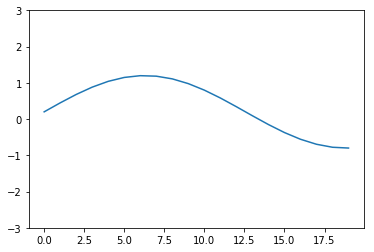

In [24]:
# # Now, those are just some samples... Let's create an actual dataset
# training_samples = []
# for a in range(5000):
# #     w1, w2 = np.random.randint(1, 4), np.random.randint(5, 15)
# #     w1, w2 = np.random.normal(0, 1), np.random.normal(0, 1)
    
# #     h0 = w1
# #     h1 = np.sin(w2 * xs)
# #     y = h0 + h1
# #     y = (w1) * xs + w2
#     sentence_factor = np.random.choice([-1,0,1], 1)
# #     print(sentence_factor)
#     speaker_factor = np.random.choice(np.arange(0,2,0.2), 1)
# #     print(speaker_factor)
#     y = sentence_factor * np.sin(xs) + speaker_factor


#     training_samples.append(torch.unsqueeze(torch.unsqueeze(torch.Tensor(y), 0),0))
    
# print(f'We collected {len(training_samples)} samples')

# # plt.plot(training_samples[0].numpy())
# plt.plot(training_samples[np.random.randint(0,1999)][0][0].numpy())
# plt.ylim(-3,3)

In [98]:



class FHVAE(nn.Module):
    def __init__(self):
        super(FHVAE, self).__init__()
        
        # encoder/inference
        
        # z2/sequence level
        self.lstm_z2 = nn.GRU(20,30)
        self.mlp_mean_z2 = nn.Sequential(nn.Linear(30,20), nn.Tanh(),nn.Linear(20,20), nn.Tanh(), nn.Linear(20,1))
        self.mlp_std_z2 = nn.Sequential(nn.Linear(30,20), nn.Tanh(), nn.Linear(20,20), nn.Tanh(),nn.Linear(20,1))
        
        # z1/segment level
        self.lstm_z1 = nn.GRU(21,30)
        self.mlp_mean_z1 = nn.Sequential(nn.Linear(30,20), nn.Tanh(), nn.Linear(20,10), nn.Tanh(), nn.Linear(10,1))
        self.mlp_std_z1 = nn.Sequential(nn.Linear(30,20), nn.Tanh(), nn.Linear(20,10), nn.Tanh(), nn.Linear(10,1))
        
        
        # decoder/generative
#         self.mlp_mean_x = nn.Sequential(nn.Linear(4,50), nn.ReLU(), nn.Linear(50,100))
#         self.mlp_std_x = nn.Sequential(nn.Linear(4,50), nn.ReLU(), nn.Linear(50,100))

        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps= torch.empty(mu.size()).normal_(mean=0,std=1)#.unsqueeze(0) # works quite well
        
        return mu + eps*std
    
    
    def forward(self, x):
#         # encode
#         # z2
# #         _, (h_z2, c_z2) = self.lstm_z2(x)
        _, h_z2 = self.lstm_z2(x)

        mu_z2 = self.mlp_mean_z2(h_z2)
        std_z2 = self.mlp_std_z2(h_z2)   
        
        z2 = self.reparameterize(mu_z2, std_z2)
        
        
        # z1
#         _, (h_z1, c_z1) = self.lstm_z1(torch.cat((x.squeeze(), z2[0,0])).unsqueeze(0).unsqueeze(0))
        _, h_z1 = self.lstm_z1(torch.cat((x.squeeze(), z2[0,0])).unsqueeze(0).unsqueeze(0))
        
        mu_z1 = self.mlp_mean_z1(h_z1)
        std_z1 = self.mlp_std_z1(h_z1)   
        
        z1 = self.reparameterize(mu_z1, std_z1)
        
        
        # decode
        reconstruction = z1 * torch.sin(torch.Tensor(xs)) + z2
        
        return reconstruction, (mu_z1,std_z1), (mu_z2,std_z2)
        
        

# model = FHVAE()

# # print(model)
# reconstruction, p_z1, p_z2 = model(torch.Tensor(training_samples[0]))


# reconstruction

In [28]:
# class Baseline(nn.Module):
#     def __init__(self):
#         super(Baseline, self).__init__()
        
#         self.lstm = nn.LSTM(20, 30)
#         self.mlp1 = nn.Sequential(nn.Linear(30,20), nn.ReLU(), nn.Linear(20,1))
        
#         self.mlp2 = nn.Sequential(nn.Linear(30,20), nn.ReLU(), nn.Linear(20,1))
#     def forward(self, x):
#         _, (h, c) = self.lstm(x)
#         z2 = self.mlp1(h)
#         z1 = self.mlp2(h)
        
# #         reconstruction = z2 + torch.sin(z1.squeeze() * torch.Tensor(xs))
#         reconstruction = z2 + z1.squeeze() * torch.sin(torch.Tensor(xs))

        
        
#         return reconstruction    
# def baseline_loss(recon_x,
#                   x):

    
#     BCE = F.binary_cross_entropy(torch.sigmoid(recon_x), torch.sigmoid(x)) # reconstruction loss
# #     KLD_z1 = -0.5 * torch.sum(1 + logvar_z1 - mu_z1.pow(2) - logvar_z1.exp()) # KL-divergence from N(0,1)
# #     KLD_z2 = -0.5 * torch.sum(1 + logvar_z2 - mu_z2.pow(2) - logvar_z2.exp()) # KL-divergence from N(0,1)

#     return BCE# + 1*(KLD_z1 + KLD_z2)# + tau * KLD

In [69]:
def loss_function(recon_x,
                  x,
                  mu_z1, logvar_z1,
                  mu_z2, logvar_z2,
                  tau=1):

    
    BCE = F.binary_cross_entropy(torch.sigmoid(recon_x), torch.sigmoid(x)) # reconstruction loss
    KLD_z1 = -0.5 * torch.sum(1 + logvar_z1 - mu_z1.pow(2) - logvar_z1.exp()) # KL-divergence from N(0,1)
    KLD_z2 = -0.5 * torch.sum(1 + logvar_z2 - mu_z2.pow(2) - logvar_z2.exp()) # KL-divergence from N(0,1)

    return BCE# + 1*(KLD_z1 + KLD_z2)# + tau * KLD

In [123]:
# def plot_grad_flow(named_parameters):
#     ave_grads = []
#     layers = []
#     for n, p in named_parameters:
#         if(p.requires_grad) and ("bias" not in n):
#             layers.append(n)
#             ave_grads.append(p.grad.abs().mean())
    
#     plt.plot(ave_grads, alpha=0.3, color="#DF2935", marker='.', linestyle='None', ms=2)
# #     plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
#     plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
#     plt.ylim(ymin=0, ymax=0.1)
#     plt.xlim(xmin=0, xmax=len(ave_grads))
#     plt.xlabel("Layers")
#     plt.ylabel("average gradient")
#     plt.title("Gradient flow")
#     plt.grid(True)

In [126]:
# for i in range(500):
#     x = training_samples[i]

#     reconstruction, p_z1, p_z2  = model(x)

#     loss = loss_function(reconstruction, x, p_z1[0], p_z1[1], p_z2[0], p_z2[1])
#     loss.backward()

# #     if i > 150:
#     plot_grad_flow(model.named_parameters())

#     optimizer.step()

# # plot_grad_flow(model.named_parameters())


In [72]:
# ave_grads = []
# layers = []


def train_single_epoch(model, optimizer, data):

    model.train()
    train_loss = 0
    i = 0
    for x in data:
        i += 1
        reconstruction, p_z1, p_z2  = model(x)
#         reconstruction = model(x)

        loss = loss_function(reconstruction, x, p_z1[0], p_z1[1], p_z2[0], p_z2[1])
#         loss = baseline_loss(reconstruction, x)

        loss.backward()
        ############################
#         if i>4900:
#         plot_grad_flow(model.named_parameters())

        ###############################
        optimizer.step()

        train_loss += loss.item()

    return train_loss / i  # /dataloader.size() #->normalize


Epoch: 0, Loss: 0.55
Epoch: 100, Loss: 0.49
Epoch: 200, Loss: 0.60
Epoch: 300, Loss: 0.45
Epoch: 400, Loss: 0.63
Epoch: 500, Loss: 0.63
Epoch: 600, Loss: 0.40
Epoch: 700, Loss: 0.61
Epoch: 800, Loss: 0.48
Epoch: 900, Loss: 0.35


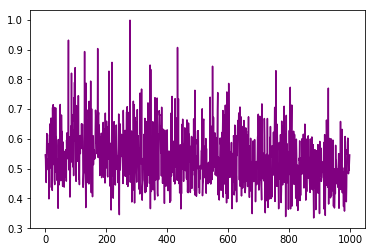

In [116]:
# model = Baseline()
# model = FHVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6) # 0.001
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
# plt.figure(figsize=(12,10))
# train_single_epoch(model, optimizer, training_samples)


losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    loss = train_single_epoch(model, optimizer, training_samples)
    losses.append(loss)
    if epoch%100==0:
        print('Epoch: {}, Loss: {:.2f}'.format(epoch, loss))
torch.save(model.state_dict(), 'model_credit_score_1000.pth')
plt.plot(losses, color='purple')
plt.show()


In [140]:
# print(len(training_samples))

In [139]:
# plt.plot(ave_grads, alpha=0.3, color="b")
# # plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
# # plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
# plt.xlim(xmin=0, xmax=len(ave_grads))
# plt.xlabel("Layers")
# plt.ylabel("average gradient")
# plt.title("Gradient flow")
# plt.grid(True)

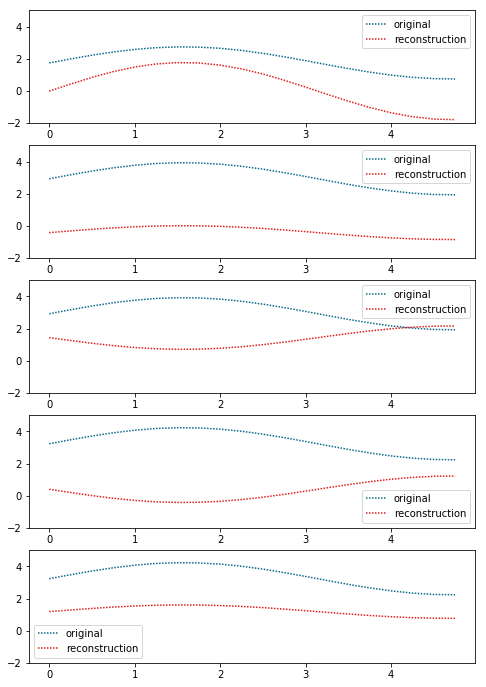

In [126]:

# torch.save(model.state_dict(), 'example_model.pth')


fig, axes = plt.subplots(nrows=5,ncols=1,figsize=(8,12))


for a in range(5):
    y = training_samples[np.random.randint(0,4)].numpy()[0][0]
    y_reconstructed, _, _ = model(training_samples[a])
#     y_reconstructed = model(training_samples[a])

    y_reconstructed = y_reconstructed.squeeze().detach().numpy()
    # for comparison
    w1, w2 = np.random.normal(0, 1), np.random.normal(0, 1)


    axes[a].plot(xs, y,linestyle = (0, (1,1)), color = '#086788', label='original')
    axes[a].plot(xs, y_reconstructed,linestyle = (0, (1,1)), color = '#DD1C1A', label='reconstruction')
   
    
    axes[a].set_ylim(-2,5)
    axes[a].legend()

# plt.legend()
plt.show()


In [130]:
def log_gauss(x, mu, logvar):
    log_2pi = torch.FloatTensor([np.log(2 * np.pi)])
    return -0.5 * (log_2pi + logvar.data + torch.pow(x.data - mu.data, 2) / torch.exp(logvar.data))

def kld(p_mu, p_logvar, q_mu, q_logvar):
    return -0.5 * (1 + p_logvar.data - q_logvar.data - (torch.pow(p_mu.data - q_mu.data, 2) + torch.exp(p_logvar.data)) / torch.exp(q_logvar.data))

x = torch.Tensor([0,0,1])
mu = torch.Tensor([0])
logvar = torch.Tensor([1])
log_gauss(x, mu,logvar)
# kld(mu+10,logvar,mu,logvar)

tensor([-1.4189, -1.4189, -1.6029])